### Импорты ###

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

Описание импортов:

numpy — для работы с массивами и математическими операциями.

pandas — для анализа и обработки табличных данных.

matplotlib.pyplot as plt — библиотека для визуализации данных (графики, гистограммы, диаграммы и др.).

import seaborn as sns — для визуализации данных.

LinearRegression, Lasso, Ridge — линейные модели регрессии (обычная, с L1- и L2-регуляризацией).

RobustScaler — масштабирование данных, устойчивое к выбросам.

mean_squared_log_error — метрика качества: средняя квадратичная логарифмическая ошибка.

train_test_split — разделение данных на обучающую и тестовую выборки.

TransformedTargetRegressor — регрессор с преобразованием целевой переменной.

FunctionTransformer — преобразование данных с помощью произвольной функции.

### Загрузка данных ###

In [260]:
train_data = pd.read_csv('train_hw.csv')
test_data = pd.read_csv('test_hw.csv')

In [261]:
print("Размер train данных:", train_data.shape)
print("Размер test данных:", test_data.shape)
print("\nПервые 5 строк train данных:")
display(train_data.head())
print("\nИнформация о train данных:")
train_data.info()

Размер train данных: (1168, 81)
Размер test данных: (292, 80)

Первые 5 строк train данных:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,20,RL,NaN,8750,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal,148500
1,2,160,RM,24.0,2368,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,125000
2,3,60,RL,80.0,9760,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,167900
3,4,120,RM,NaN,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,165000
4,5,80,RL,NaN,14112,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,180500



Информация о train данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    959 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          71 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-

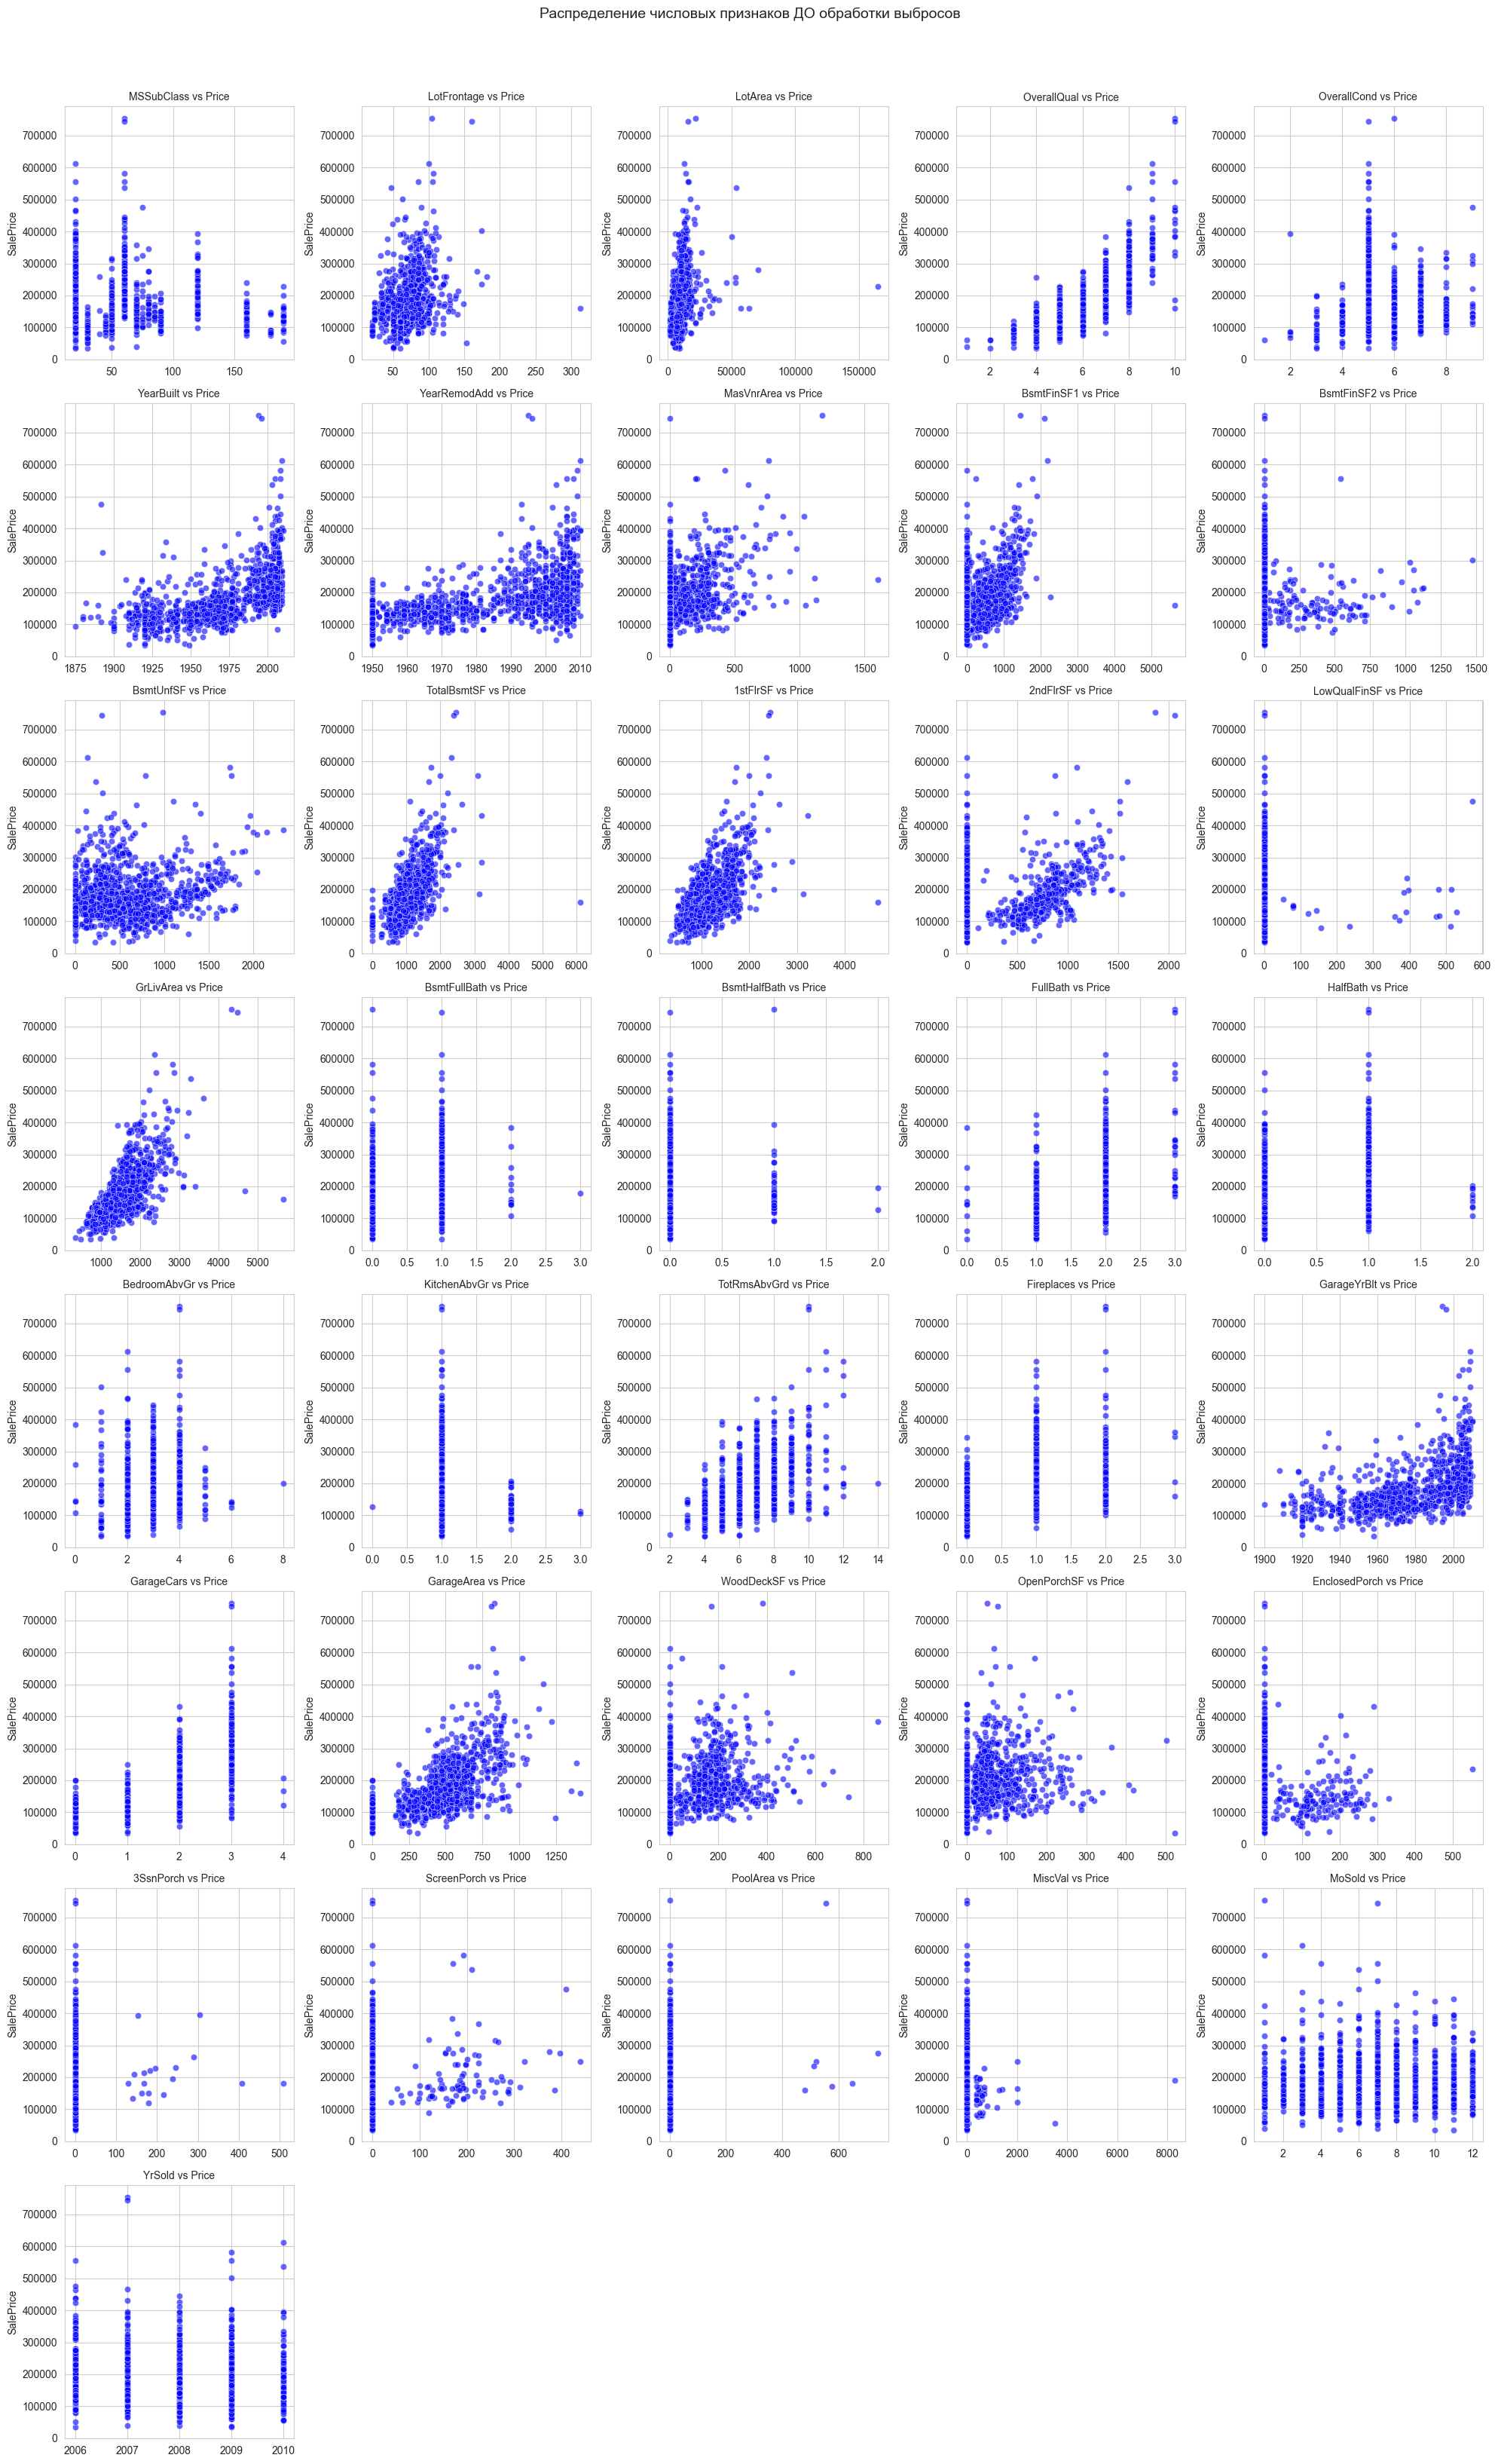

In [262]:
# Выбираем только числовые колонки (исключая ID)
num_cols = train_data.select_dtypes(include=['int64', 'float64']).drop(['Id', 'SalePrice'], axis=1, errors='ignore')

# Создаем сетку графиков
n_cols = 5
n_rows = int(np.ceil(len(num_cols.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
plt.suptitle("Распределение числовых признаков ДО обработки выбросов", y=1.02, fontsize=14)

# Строим scatterplot для каждого признака
for i, col in enumerate(num_cols.columns):
    ax = axes.flatten()[i]
    sns.scatterplot(
        x=train_data[col],
        y=train_data['SalePrice'],
        ax=ax,
        alpha=0.6,
        color='blue'
    )
    ax.set_title(f'{col} vs Price', fontsize=10)
    ax.set_xlabel('')

# Скрываем пустые графики
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

### Обработка пропущенных значений ###

Для начала соберем статистику, связанную с NaN-ми. Узнаем, какие ячейки имеют недостающие значения (в процентах).

In [263]:
nan_df = (train_data.isnull().mean() * 100).reset_index()
nan_df

,index,0
0,Id,0.000000
1,MSSubClass,0.000000
2,MSZoning,0.000000
3,LotFrontage,17.893836
4,LotArea,0.000000
...,...,...
76,MoSold,0.000000
77,YrSold,0.000000
78,SaleType,0.000000
79,SaleCondition,0.000000


Теперь преобразуем датафрейм в более понятный вид

In [264]:
nan_df.columns = ["column_name", "percentage"]
nan_df.sort_values("percentage", ascending=False, inplace=True)
nan_df.head(10)

,column_name,percentage
72,PoolQC,99.400685
74,MiscFeature,96.318493
6,Alley,93.921233
73,Fence,81.678082
25,MasVnrType,59.417808
57,FireplaceQu,46.832192
3,LotFrontage,17.893836
63,GarageQual,5.650685
60,GarageFinish,5.650685
58,GarageType,5.650685


Квантили:

In [265]:
intro_srt = "Number of columns with more than"
for percent in (80, 50, 20, 5):
    print(f"{intro_srt} {percent}% NANs: {(nan_df.percentage > percent).sum()}")

Number of columns with more than 80% NANs: 4
Number of columns with more than 50% NANs: 5
Number of columns with more than 20% NANs: 6
Number of columns with more than 5% NANs: 12


Столбцы с более чем 80% NaN. Их будем удалять, тк эти столбцы имеют экстремально высокий процент пропусков (>80%). Они несут очень мало информации

In [266]:
nan_columns = list(nan_df[nan_df.percentage > 80]['column_name'])
nan_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [267]:
train_with_80 = [col for col in train_data.columns if train_data[col].isnull().mean() * 100 > 80]
train_data = train_data.drop(train_with_80, axis=1)
test_data = test_data.drop([col for col in train_with_80 if col in test_data.columns], axis=1)
print(f"Удалены столбцы с >80% пропусков: {train_with_80}")

Удалены столбцы с >80% пропусков: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


### Преобразование MSSubClass в категориальный

Преобразование в строковый необходимо, так как исходные числовые значения фактически являются категориальными метками без математической интерпретации.

In [268]:
for df in [train_data, test_data]:
    df['MSSubClass'] = df['MSSubClass'].astype(str)

### Кодирование порядковых категориальных признаков

In [269]:
ordinal_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
fintype_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}

ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
            'KitchenQual', 'GarageQual', 'GarageCond', 'FireplaceQu']
fin_cols = ['BsmtFinType1', 'BsmtFinType2']

In [270]:
for df in [train_data, test_data]:
    for col in ord_cols:
        if col in df.columns:
            df[col] = df[col].map(ordinal_map).fillna(0)

    for col in fin_cols:
        if col in df.columns:
            df[col] = df[col].map(fintype_map).fillna(0)

    if 'BsmtExposure' in df.columns:
        df['BsmtExposure'] = df['BsmtExposure'].map(expose_map).fillna(0)

### Создание новых признаков

TotalLot: Общая площадь участка (фронт + площадь) — объединяет два взаимодополняющих параметра лота

TotalBsmtFin: Суммарная отделанная площадь подвала — важнее общий метраж, чем по частям

TotalSF: Общая жилая площадь (подвал + второй этаж) — ключевой параметр для оценки недвижимости

TotalBath: Взвешенная сумма санузлов (полные = 1, полуванные = 0.5) — точнее отражает

TotalPorch: Общая площадь веранд/террас — объединяет разрозненные параметры

In [271]:
for df in [train_data, test_data]:
    # Основные комбинированные признаки
    df['TotalLot'] = df['LotFrontage'].fillna(0) + df['LotArea']
    df['TotalBsmtFin'] = df['BsmtFinSF1'].fillna(0) + df['BsmtFinSF2'].fillna(0)
    df['TotalSF'] = df['TotalBsmtSF'].fillna(0) + df['2ndFlrSF'].fillna(0)
    df['TotalBath'] = (df['FullBath'].fillna(0) +
                       df['HalfBath'].fillna(0) * 0.5 +
                       df['BsmtFullBath'].fillna(0) +
                       df['BsmtHalfBath'].fillna(0) * 0.5)
    df['TotalPorch'] = (df['OpenPorchSF'].fillna(0) +
                        df['EnclosedPorch'].fillna(0) +
                        df['ScreenPorch'].fillna(0))

    # Дополнительные engineered признаки
    df['LivLotRatio'] = df['GrLivArea'] / df['LotArea'].replace(0, 1)
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['IsNew'] = (df['YearBuilt'] == df['YrSold']).astype(int)

    # Бинарные признаки наличия
    cols = ['MasVnrArea', 'TotalBsmtFin', 'TotalBsmtSF', '2ndFlrSF', 'WoodDeckSF', 'TotalPorch']
    for col in cols:
        if col in df.columns:
            df[f'{col}_bin'] = df[col].apply(lambda x: 1 if x > 0 else 0)

GrLivArea и LotArea по отдельности не всегда отражают ценность. LivLotRatio показывает, насколько плотно застроен участок:

Высокое значение - дом занимает почти весь участок (может быть дешевле).

Низкое значение - большой участок с небольшим домом (часто премиум-класс).

Ожидается, что дома с низким LivLotRatio, т.е. в которых больше свободного места, будут дороже.

<Axes: xlabel='LivLotRatio', ylabel='SalePrice'>

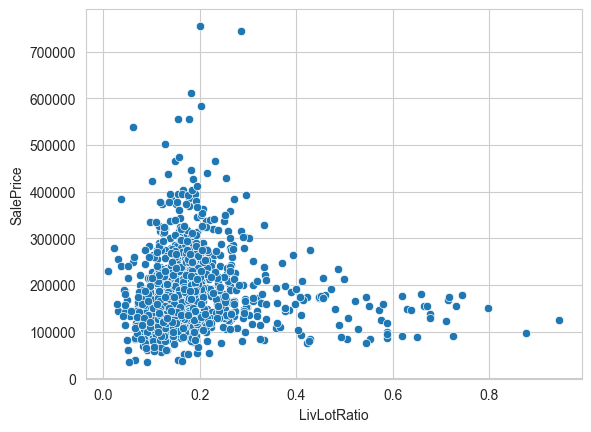

In [272]:
sns.scatterplot(x='LivLotRatio', y='SalePrice', data=train_data)  

Обычно новые дома ценятся выше, чем старые.
Ожидаем нисходящий тренд, но с возможными пиками для исторически интересных домов. 

<Axes: xlabel='Age', ylabel='SalePrice'>

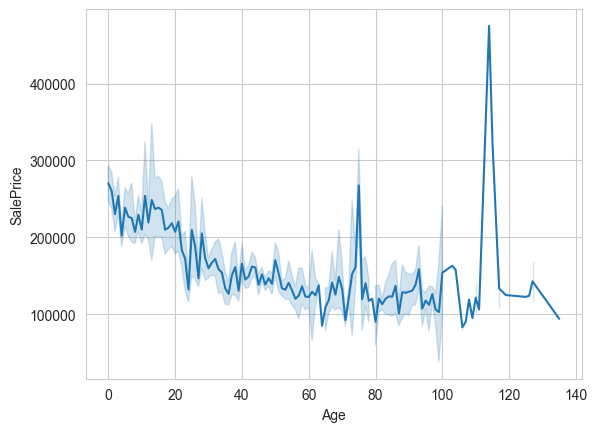

In [273]:
sns.lineplot(x='Age', y='SalePrice', data=train_data)  

Время с последнего ремонта.
Если RemodAge = Age, значит ремонта не было. Это может снижать цену.
А есои RemodAge < 5, то недавний ремонт может, наоборот, повысить цену.

Новостройки объективно ценятся выше. Если в данных есть дома с YearBuilt == YrSold, их можно выделять как премиум-сегмент. Ниже приведены средние цены нового (1) и не нового (0) домов.

In [274]:
train_data.groupby('IsNew')['SalePrice'].mean()  

IsNew
0    176828.135426
1    270244.320755
Name: SalePrice, dtype: float64

Иногда факт наличия важнее точного размера (например, камин или подвал). Бинарные признаки упрощают модель для редких признаков. Ниже можно заметить, что разнице в цене домов с облицовкой (1) и без нее (0) существенна. Значит этот признак явно влияет на цену, поэтому его стоит включить в модель для улучшения прогноза.

In [275]:
print(train_data.groupby('MasVnrArea_bin')['SalePrice'].mean())  

MasVnrArea_bin
0    157496.347323
1    215212.461216
Name: SalePrice, dtype: float64


### Разделение столбцов

In [276]:
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.drop('SalePrice', errors='ignore')
cat_cols = train_data.select_dtypes(include=['object']).columns

### Заполнение пропусков


<Axes: xlabel='Neighborhood', ylabel='GarageArea_mean'>

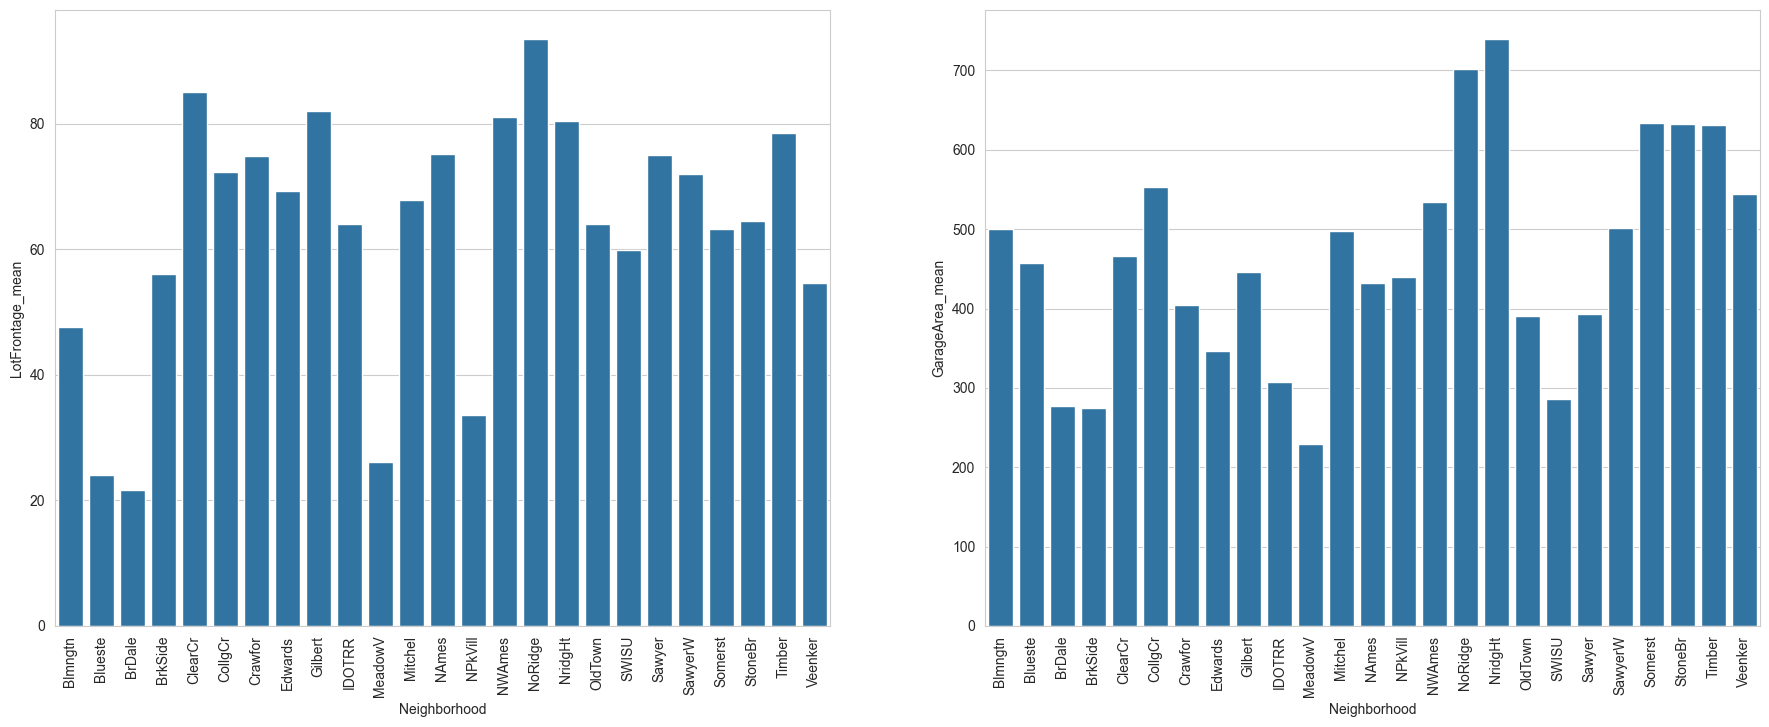

In [277]:
neigh_grouped = train_data.groupby('Neighborhood')
neigh_lot = (
    neigh_grouped['LotFrontage'].mean()
    .reset_index(name='LotFrontage_mean')
)
neigh_garage = (
    neigh_grouped['GarageArea'].mean()
    .reset_index(name='GarageArea_mean')
)

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

В данном примере свойства домов сильно зависят от того, в каком районе они расположены. Поэтому средние значения лучше считать по районам. Категориальные признаки заполним модой.

In [278]:
for col in num_cols:
    if train_data[col].isnull().any():
        train_data[col] = train_data.groupby('Neighborhood')[col].transform(lambda x: x.fillna(x.mean()))
        if col in test_data.columns:
            test_data[col] = test_data.groupby('Neighborhood')[col].transform(lambda x: x.fillna(x.mean()))

# Заполняем пропуски глобальным средним (если после группировки по районам остались незаполненные значения).
train_data[num_cols] = train_data[num_cols].fillna(train_data[num_cols].mean())
test_data[num_cols] = test_data[num_cols].fillna(train_data[num_cols].mean())

# Категориальные признаки заполняем модой
for col in cat_cols:
    if train_data[col].isnull().any():
        mode_val = train_data[col].mode()[0]
        train_data[col] = train_data[col].fillna(mode_val)
        if col in test_data.columns:
            test_data[col] = test_data[col].fillna(mode_val)

### Удаление нефункциональных столбцов

Некоторые признаки в основном состоят из одного значения или нулей, что не особо полезно. Поэтому мы устанавливаем пороговое значение - на уровне 96%. Если столбец имеет более 96% от одного и того же значения, считаем признак бесполезными и удалиям его. Т.е. находим столбцы, где одно значение встречается чаще threshold случаев.

In [279]:
def get_almost_constant_columns(df, threshold=96, dropna=True):
    overfit_columns = []
    for col in df.columns:
        if dropna:
            counts = df[col].dropna().value_counts()
        else:
            counts = df[col].value_counts()

        if len(counts) == 0:
            continue

        most_common_percent = (counts.iloc[0] / len(df)) * 100
        if most_common_percent > threshold:
            overfit_columns.append(col)
    return overfit_columns

# Для категориальных признаков
cat_cols = train_data.select_dtypes(include=['object']).columns
overfit_cat = get_almost_constant_columns(train_data[cat_cols])
print(f"Удаляемые категориальные признаки (>{96}% одного значения): {overfit_cat}")

Удаляемые категориальные признаки (>96% одного значения): ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']


### Обработка выбросов

Удаление выбросов предотвратит воздействие экстремальных значений на производительность модели.
Из скаттерплотов выше мы можем увидеть, что следующие признаки имеют экстремальные выбросы:

* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

Мы уберем выбросы на основе определенного порогового значения.
Эти значения мы получим из боксплотов ("ящик с усиками"):

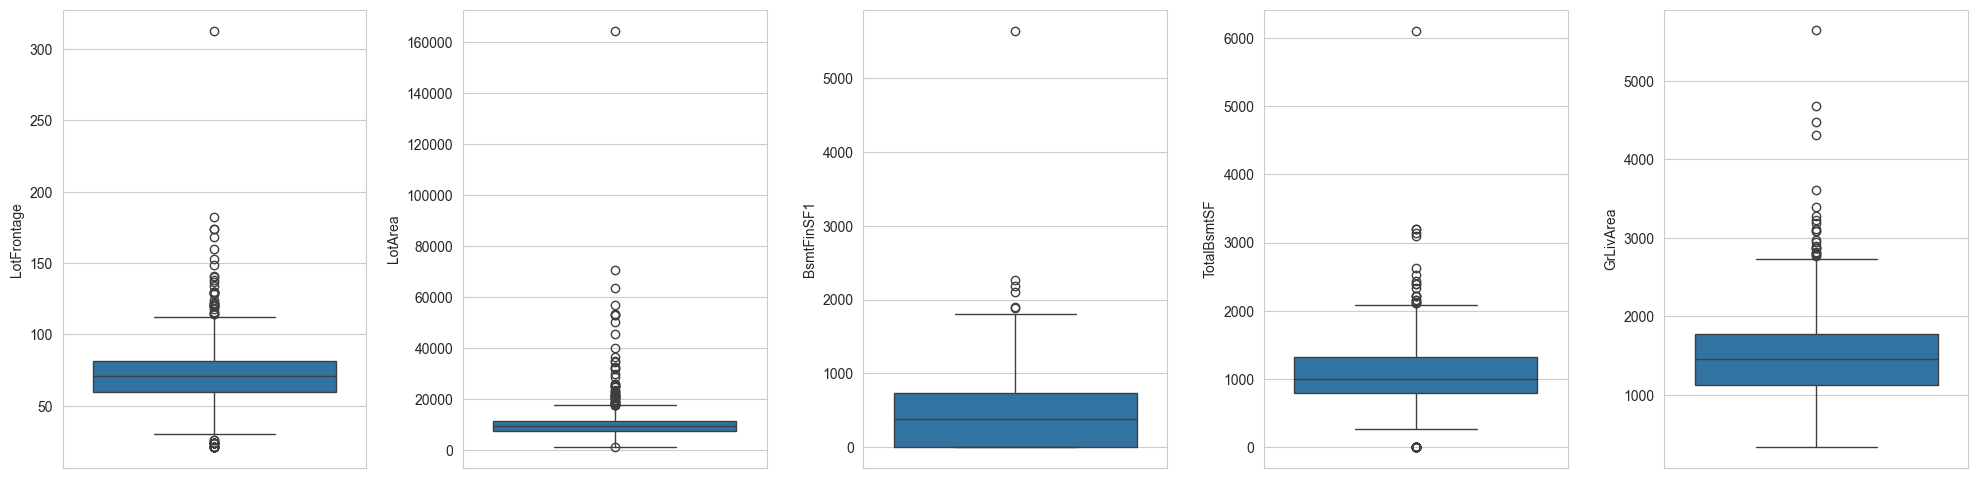

In [280]:
out_col = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea']

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axes, out_col):
    sns.boxplot(y=train_data[col], data=train_data, ax=ax)
fig.tight_layout(pad=1.5)

In [281]:
outlier_bounds = {
    'LotFrontage': 200,
    'LotArea': 100000,
    'BsmtFinSF1': 4000,
    'TotalBsmtSF': 5000,
    'GrLivArea': 4000
}

# Удаление выбросов
initial_count = len(train_data)
for col, bound in outlier_bounds.items():
    if col in train_data.columns:
        train_data = train_data[train_data[col] <= bound]

removed_count = initial_count - len(train_data)
print(f"Удалено {removed_count} строк ({removed_count / initial_count:.1%}) из-за выбросов")

Удалено 5 строк (0.4%) из-за выбросов


### Скейлинг

In [282]:
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(['Id', 'SalePrice'], errors='ignore')

# Применение RobustScaler
scaler = RobustScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])
test_data[num_cols] = scaler.transform(test_data[num_cols])

### One-Hot Encoding для всех категориальных признаков

Преобразуем оставшиеся категориальные столбцы с помощью one-hot-encoding с помощью метода get_dummies() в числовые столбцы, которые подходят для подачи в алгоритм машинного обучения.

In [283]:
cat_cols = train_data.select_dtypes(include=['object']).columns
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']

X_encoded = pd.get_dummies(X, columns=cat_cols)
test_encoded = pd.get_dummies(test_data.drop('Id', axis=1), columns=cat_cols)

### Синхронизация колонок между train и test


In [284]:
all_cols = X_encoded.columns
for col in all_cols:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
test_encoded = test_encoded[all_cols]

### Разделение на train/val


In [285]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2)

### Обучение моделей с трансформацией таргета

In [286]:
models = {
    'LinearRegression': TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log1p,
        inverse_func=np.expm1
    ),
    'Lasso': TransformedTargetRegressor(
        regressor=Lasso(alpha=0.0005, max_iter=50000),
        func=np.log1p,
        inverse_func=np.expm1
    ),
    'Ridge': TransformedTargetRegressor(
        regressor=Ridge(alpha=10),
        func=np.log1p,
        inverse_func=np.expm1
    )
}

In [287]:
best_msle = float('inf')
best_model = None

for name, model in models.items():
    print(f"\n=== Обучение {name} ===")
    model.fit(X_train, y_train)

    # Предсказания (уже преобразованы обратно через inverse_func)
    val_pred = model.predict(X_val)
    val_pred = np.maximum(val_pred, 0)  # Защита от отрицательных значений

    # Для train предсказаний
    train_pred = model.predict(X_train)
    train_pred = np.maximum(train_pred, 0)

    # Расчет MSLE
    msle_train = mean_squared_log_error(y_train, train_pred)
    msle_val = mean_squared_log_error(y_val, val_pred)

    print(f"Ненулевых коэффициентов: {(model.regressor_.coef_ != 0).sum()}/{len(model.regressor_.coef_)}")
    print(f"MSLE на train: {msle_train:.5f}")
    print(f"Validation MSLE: {msle_val:.5f}")

    if msle_val < best_msle:
        best_msle = msle_val
        best_model = model
        print(f"Новая лучшая модель: {name}")


=== Обучение LinearRegression ===
Ненулевых коэффициентов: 254/256
MSLE на train: 0.00751
Validation MSLE: 0.01656
Новая лучшая модель: LinearRegression

=== Обучение Lasso ===
Ненулевых коэффициентов: 101/256
MSLE на train: 0.00967
Validation MSLE: 0.01515
Новая лучшая модель: Lasso

=== Обучение Ridge ===
Ненулевых коэффициентов: 254/256
MSLE на train: 0.00915
Validation MSLE: 0.01566


### Финальное обучение на всех данных

In [288]:
print("\nФинальное обучение лучшей модели на всех данных...")
best_model.fit(X_encoded, y)
print(f"Лучшая модель: {type(best_model.regressor_).__name__}")
print(f"Лучший MSLE: {best_msle:.5f}")


Финальное обучение лучшей модели на всех данных...
Лучшая модель: Lasso
Лучший MSLE: 0.01515


### Предсказание на тестовых данных

In [289]:
test_pred = np.maximum(best_model.predict(test_encoded), 0)

### Создание файла с результатами

In [290]:
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_pred
})
submission.to_csv('submission.csv', index=False)
print("\nФайл submission.csv успешно создан!")

# Проверка распределения предсказаний
print("\nСтатистика предсказаний:")
print(f"Min: {test_pred.min():.2f}")
print(f"Max: {test_pred.max():.2f}")
print(f"Mean: {test_pred.mean():.2f}")
print(f"Median: {np.median(test_pred):.2f}")


Файл submission.csv успешно создан!

Статистика предсказаний:
Min: 68362.99
Max: 624085.58
Mean: 181377.32
Median: 166072.49


### Выводы

Наилучший результат показала Lasso-регрессия с MSLE 0.01515 на валидационной выборке, что на 8.5% лучше, чем у обычной линейной регрессии (0.01656). При этом Lasso автоматически отобрала только 101 наиболее значимый признак из 256, что делает модель более интерпретируемой и устойчивой к переобучению. Ridge-регрессия заняла промежуточное положение с MSLE 0.01566, сохранив почти все коэффициенты (254/256), но показав чуть худший результат по сравнению с Lasso. Обычная линейная регрессия без регуляризации продемонстрировала самое низкое качество на валидации (MSLE 0.01656) из-за явных признаков переобучения - разница между ошибкой на обучающей (0.00751) и валидационной выборках составила 0.00905, что значительно больше, чем у регуляризованных моделей. Эти результаты убедительно доказывают эффективность использования регуляризации - оба метода (Lasso и Ridge) обеспечили более стабильное качество предсказаний на новых данных, при этом Lasso дополнительно дала преимущество в виде отбора признаков, упрощающего модель без потери точности. Предсказанные цены находятся в реалистичном диапазоне от 68к до 624к.